# Convert Accent format to Babcock lab calibration
* load json structure created by micromanager accent plugin by ries lab
* crop ROIS from multiplane calibration
* save in .npy structure as expected by babcock processing

In [56]:
import numpy as np
import json
import os
import pickle
import matplotlib.pyplot as plt

In [57]:
def load_accent_calibration(filepath):
        # Open and read the JSON file
    with open(filepath, 'r') as file:
        data = json.load(file)

    return data

def load_multiplane_calibration(filepath):
        # Open and read the JSON file
    with open(filepath, 'r') as file:
        data = json.load(file)

    return data

def convert_cal_shape(cal):
    
    for el in cal.keys():
        if not isinstance(cal[el], int) and len(cal[el]) == cal['width']*cal['height']:
            cal[el] = np.reshape(cal[el], newshape=(cal['width'],cal['height']))
    
    return cal


def crop_plane_calibration(cal, mcal, roi=None):
    # cal: scmos calibration data
    # mcal: multiplane calibration coordinates
    cal_n = {}
    for i in mcal.keys():
        cal_n[i] ={}
        for el in cal.keys():
            if not isinstance(cal[el], int) and cal[el].shape == (cal['width'],cal['height']):
                if roi is None:
                    cal_n[i][el] = crop_image(cal[el], mcal[i])
                else:
                    mcal_i_global = mcal[i] + [roi[0], roi[1], roi[0], roi[1]] # update FOV cordinates by global ROI coordinates of the screen crop
                    cal_n[i][el] = crop_image(cal[el], mcal_i_global)

    
    return cal_n

def crop_image(img, cc):
    return img[cc[0]:cc[2], cc[1]:cc[3]]


def convert_accent_to_babcock(cal, exp):
    cal_out = {}
    for i in cal.keys():
        cal_out[i] = {}
        cal_out[i]['gain'] =  cal[i]['gain']

        # offset
        # baseline + DX*t_exp
        cal_out[i]['offset'] = cal[i]['baseline']+cal[i]['dcPerSec']*exp/1000

        # variance
        # RN^2 + TN^2 *t_exp
        cal_out[i]['variance'] = cal[i]['rnSq']**2 + (cal[i]['tnSqPerSec']**2)*exp/1000

        # photon response
        # median(gain) * flatfield
        # ? no flatfield data, no way to calculate that from the baseline calibration 
        # shortcut now with gain map 
        cal_out[i]['au'] = cal[i]['gain'] #np.median(cal[i]['gain'])*cal[i]['gain']
    return cal_out


# pickle.dump([m_offset, m_variance, m_gain, m_rqe, 2], fp)
def write_calib(data, filepath):
    with open(filepath, "wb") as fp:
        pickle.dump([data['offset'], data['variance'], data['gain'], data['au'], 2], fp)

# write cal of single camera to single file  
def write_calib_all(data, filepath):
    for k,v in data.items():
        filename_out = filepath.replace('.npy', f"_{k}.npy")
        with open(filename_out, "wb") as fp:
            pickle.dump(v, fp)

def show_calib_data(cal):
    for i in cal.keys():
        f, ax = plt.subplots(1,4, figsize=(20,5))
        f.suptitle(f"Plane {i}")
        for idx, kk in enumerate(cal[i].keys()):
            ax[idx].imshow(cal[i][kk])
            ax[idx].title.set_text(f"{kk}")
            plt.colorbar(ax[idx].images[0], ax=ax[idx]) # for scale
        for idx, kk in enumerate(cal[i].keys()):
            print(f"Plane {i}, {kk}: {np.mean(cal[i][kk])} +- {np.std(cal[i][kk])}")

In [58]:
exposure_time = 50
filepath1 = r"E:\Program Files\SMAP\settings\cameras\kinetix_a21f723013.calb" # is that correct?
filepath2 = r"E:\Program Files\SMAP\settings\cameras\kinetix_a21f723014.calb"

cal1 = load_accent_calibration(filepath1)
cal2 = load_accent_calibration(filepath2)

In [73]:
root = r'D:\moritz\Technical_paper\4x2\20250825_beads_splitting_eff\PS4c_e561nm_dz50nm_4x2Scopt_1\cal_data'
filepath_mcal = os.path.join(root, "cal.json")
mcal = load_multiplane_calibration(filepath_mcal)
mcal

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\moritz\\Technical_paper\\4x2\\20250825_beads_splitting_eff\\PS4c_e561nm_dz50nm_4x2Scopt_1\\cal_data\\cal.json'

In [61]:
cal1_n = crop_plane_calibration(convert_cal_shape(cal1), mcal['fovs']['0'], mcal['global_roi']['0'])
cal2_n = crop_plane_calibration(convert_cal_shape(cal2), mcal['fovs']['1'],  mcal['global_roi']['1'])

In [62]:
cal1_out = convert_accent_to_babcock(cal1_n, exp=exposure_time)
cal2_out = convert_accent_to_babcock(cal2_n, exp=exposure_time)

In [63]:
outpath = root
#for i in cal1_out.keys(): 
#    filepath = os.path.join(outpath, f'calib_t{exposure_time}_0_{i}.npy')
#    write_calib(cal1_out[i], filepath)

#for i in cal2_out.keys(): 
#    filepath = os.path.join(outpath, f'calib_t{exposure_time}_1_{i}.npy')
#    write_calib(cal2_out[i], filepath)

In [64]:
cal_out = {}
maxkey = len(cal1_out.keys())
for i in cal1_out.keys():
    data1 = cal1_out[i]
    cal_out[i] = [data1['offset'], data1['variance'], data1['gain'], data1['au'], 2]

    cam2_i = str(int(i)+maxkey)
    data2 = cal2_out[i]
    cal_out[cam2_i] = [data2['offset'], data2['variance'], data2['gain'], data2['au'], 2]

filepath = os.path.join(outpath, f'calib.npy')
write_calib_all(cal_out, filepath)

Plane 0, gain: 3.3510736164222017 +- 0.48490922409691756
Plane 0, offset: 102.48245271548448 +- 0.8134712823147869
Plane 0, variance: 801.1039813027155 +- 2247.6494154935644
Plane 0, au: 3.3510736164222017 +- 0.48490922409691756
Plane 1, gain: 3.315294691460739 +- 0.4146658171675762
Plane 1, offset: 102.39598625086789 +- 0.8299973142581496
Plane 1, variance: 781.7881722462515 +- 2225.1717341081085
Plane 1, au: 3.315294691460739 +- 0.4146658171675762
Plane 2, gain: 3.3239576349947613 +- 0.40314335857874006
Plane 2, offset: 102.62422469821453 +- 0.8262330122176846
Plane 2, variance: 799.5769464356988 +- 2270.806510964018
Plane 2, au: 3.3239576349947613 +- 0.40314335857874006
Plane 3, gain: 3.3476752398634813 +- 1.5434710943028225
Plane 3, offset: 102.8130695849836 +- 0.887622008351006
Plane 3, variance: 814.7741615257211 +- 2524.181271971653
Plane 3, au: 3.3476752398634813 +- 1.5434710943028225


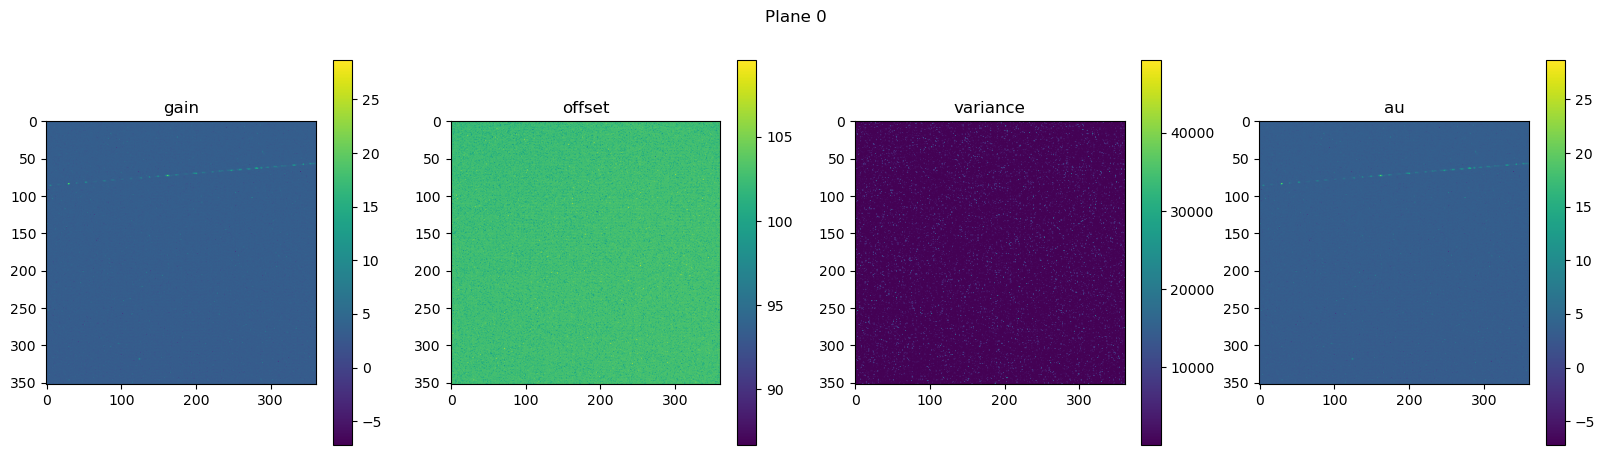

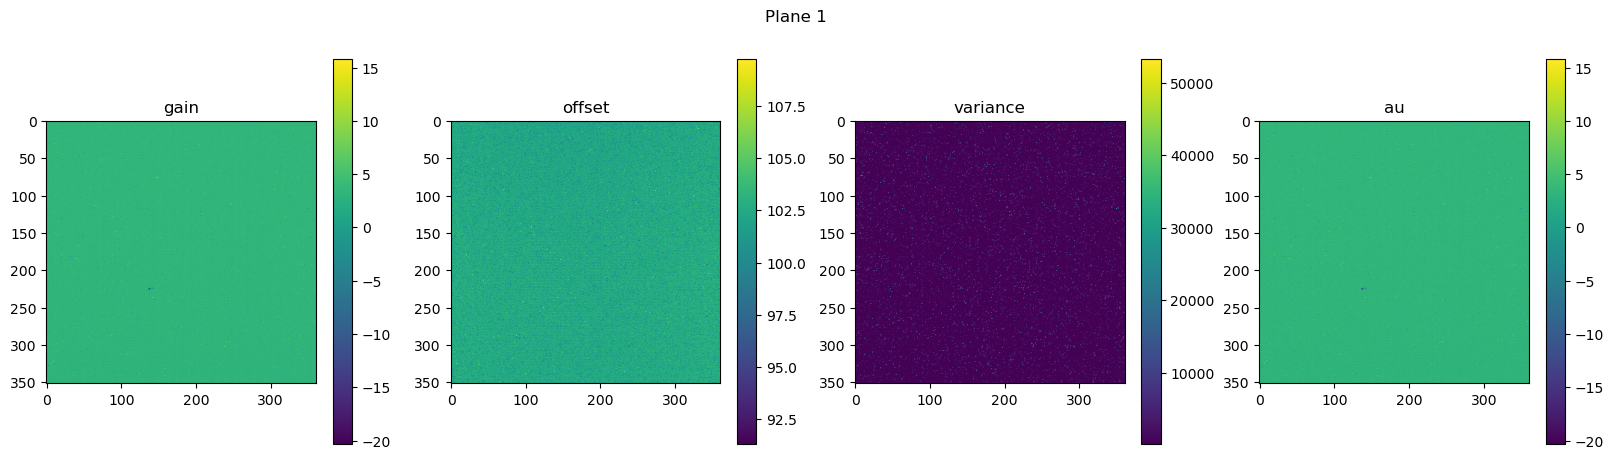

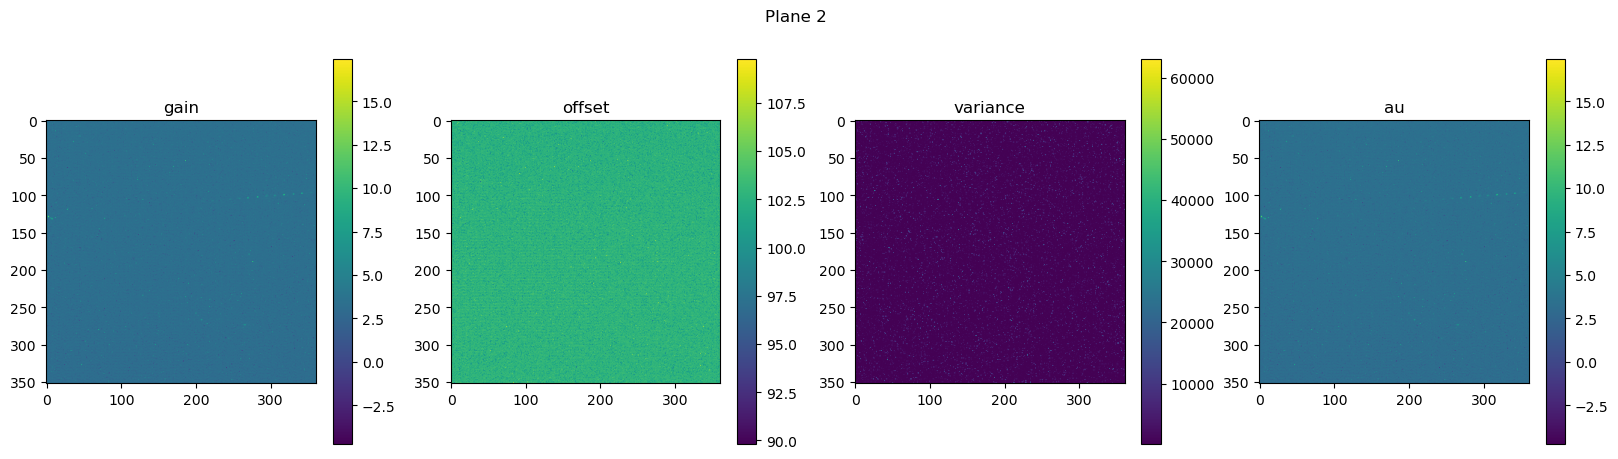

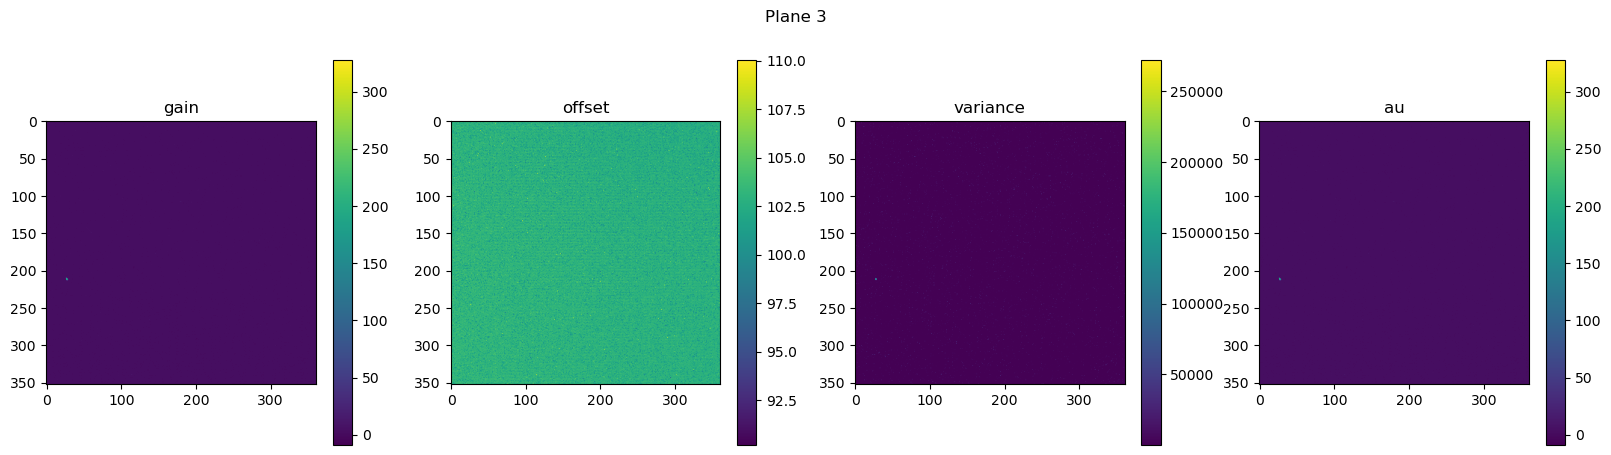

In [65]:
show_calib_data(cal1_out)

Plane 0, gain: 3.196582370584747 +- 0.42034017104937815
Plane 0, offset: 101.37470658459628 +- 0.8768770585786206
Plane 0, variance: 870.9428026590601 +- 2304.2438839853185
Plane 0, au: 3.196582370584747 +- 0.42034017104937815
Plane 1, gain: 3.1779823030810297 +- 0.41565237610000116
Plane 1, offset: 101.40909837358298 +- 0.8407540970855778
Plane 1, variance: 818.5624657618948 +- 2263.6036491119144
Plane 1, au: 3.1779823030810297 +- 0.41565237610000116
Plane 2, gain: 3.169724940230045 +- 0.4258866481394094
Plane 2, offset: 101.17100949050096 +- 0.8495623069019743
Plane 2, variance: 833.1836102722214 +- 2241.0506093356216
Plane 2, au: 3.169724940230045 +- 0.4258866481394094
Plane 3, gain: 3.192055422364053 +- 0.45715930224000967
Plane 3, offset: 101.34133105510213 +- 0.8102709831109416
Plane 3, variance: 793.8112250528393 +- 2241.0238609558737
Plane 3, au: 3.192055422364053 +- 0.45715930224000967


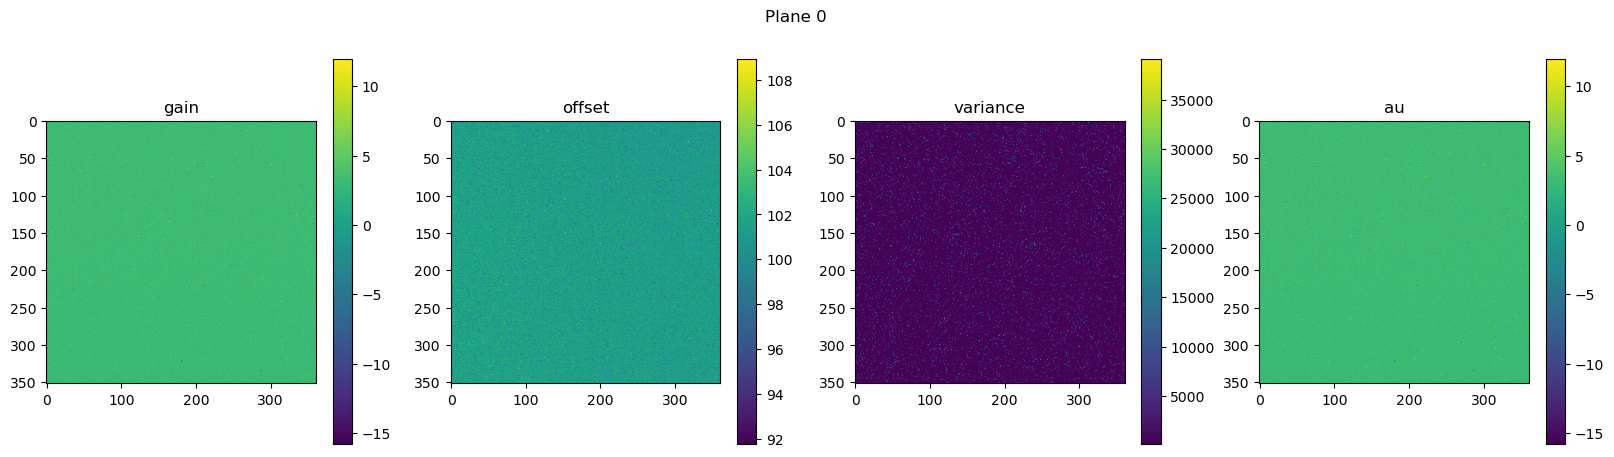

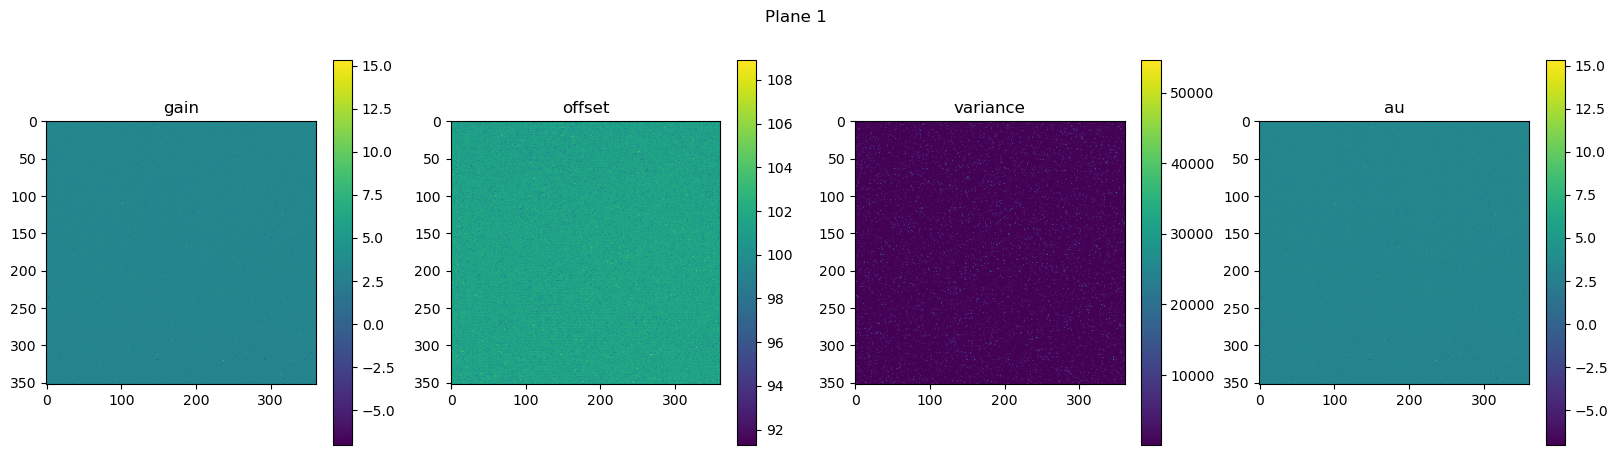

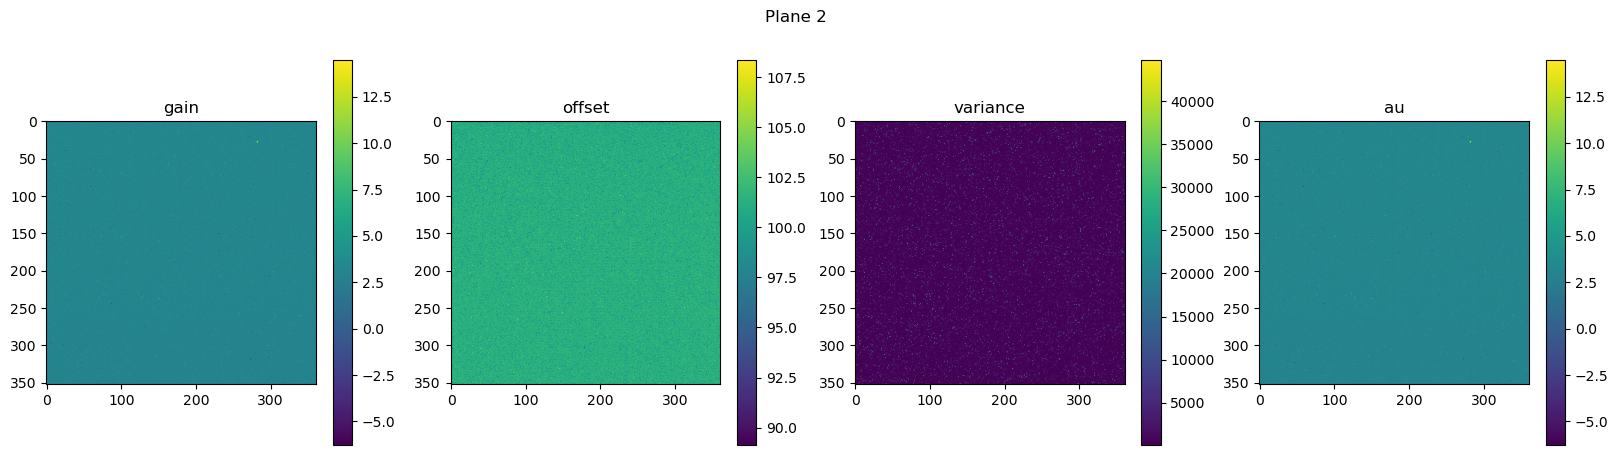

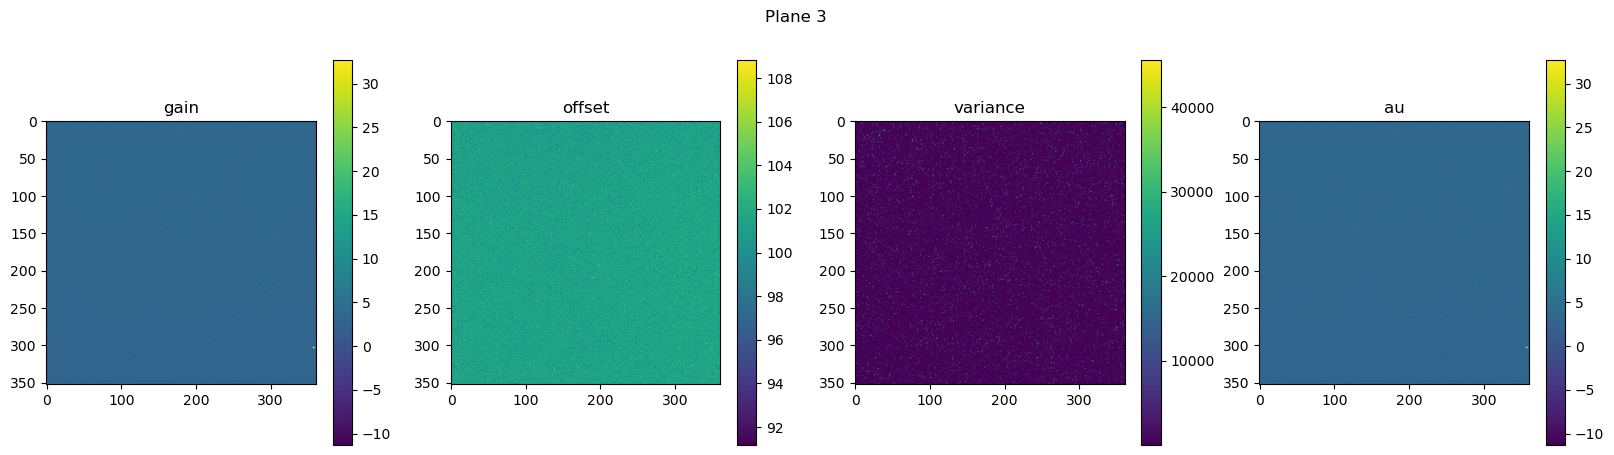

In [66]:
show_calib_data(cal2_out)

In [67]:
def convert_accent_to_babcock(cal, exp):
    cal_out = {}
    for i in cal.keys():
        cal_out[i] = {}
        cal_out[i]['gain'] =  cal[i]['gain']

        # offset
        # baseline + DX*t_exp
        cal_out[i]['offset'] = cal[i]['baseline']+cal[i]['dcPerSec']*exp/1000

        # variance
        # RN^2 + TN^2 *t_exp
        cal_out[i]['variance'] = cal[i]['rnSq']**2 + (cal[i]['tnSqPerSec']**2)*exp/1000

        # photon response
        # median(gain) * flatfield
        # ? no flatfield data, no way to calculate that from the baseline calibration 
        # shortcut now with gain map 
        cal_out[i]['au'] = cal[i]['gain'] #np.median(cal[i]['gain'])*cal[i]['gain']
    return cal_out


def create_dummy_plane_calibration(mcal, gain = 3.2, offset = 100, variance=200, au=2):
    # cal: scmos calibration data
    # mcal: multiplane calibration coordinates
    cal_n = {}
    for i in mcal.keys():
        cal_n[i] = {}
        unit_mat = np.ones((mcal[i][2]-mcal[i][0],mcal[i][3]-mcal[i][1]))
        cal_n[i]['gain'] = unit_mat*gain
        cal_n[i]['offset'] = unit_mat*offset
        cal_n[i]['variance'] = unit_mat*variance
        cal_n[i]['au'] = unit_mat*au
    
    return cal_n

## dummy calibration files 

In [68]:
cal1_dummy = create_dummy_plane_calibration(mcal['fovs']['0'])
cal2_dummy = create_dummy_plane_calibration(mcal['fovs']['1'])

In [69]:
outpath = root
cal_out = {}
maxkey = len(cal1_dummy.keys())
for i in cal1_dummy.keys():
    data1 = cal1_dummy[i]
    cal_out[i] = [data1['offset'], data1['variance'], data1['gain'], data1['au'], 2]

    cam2_i = str(int(i)+maxkey)
    data2 = cal2_dummy[i]
    cal_out[cam2_i] = [data2['offset'], data2['variance'], data2['gain'], data2['au'], 2]

filepath = os.path.join(outpath, f'calib_dummy.npy')
write_calib_all(cal_out, filepath)

Plane 0, gain: 3.200000000000001 +- 8.881784197001252e-16
Plane 0, offset: 100.0 +- 0.0
Plane 0, variance: 200.0 +- 0.0
Plane 0, au: 2.0 +- 0.0
Plane 1, gain: 3.200000000000001 +- 8.881784197001252e-16
Plane 1, offset: 100.0 +- 0.0
Plane 1, variance: 200.0 +- 0.0
Plane 1, au: 2.0 +- 0.0
Plane 2, gain: 3.200000000000001 +- 8.881784197001252e-16
Plane 2, offset: 100.0 +- 0.0
Plane 2, variance: 200.0 +- 0.0
Plane 2, au: 2.0 +- 0.0
Plane 3, gain: 3.200000000000001 +- 8.881784197001252e-16
Plane 3, offset: 100.0 +- 0.0
Plane 3, variance: 200.0 +- 0.0
Plane 3, au: 2.0 +- 0.0
Plane 0, gain: 3.200000000000001 +- 8.881784197001252e-16
Plane 0, offset: 100.0 +- 0.0
Plane 0, variance: 200.0 +- 0.0
Plane 0, au: 2.0 +- 0.0
Plane 1, gain: 3.200000000000001 +- 8.881784197001252e-16
Plane 1, offset: 100.0 +- 0.0
Plane 1, variance: 200.0 +- 0.0
Plane 1, au: 2.0 +- 0.0
Plane 2, gain: 3.200000000000001 +- 8.881784197001252e-16
Plane 2, offset: 100.0 +- 0.0
Plane 2, variance: 200.0 +- 0.0
Plane 2, au: 2.0

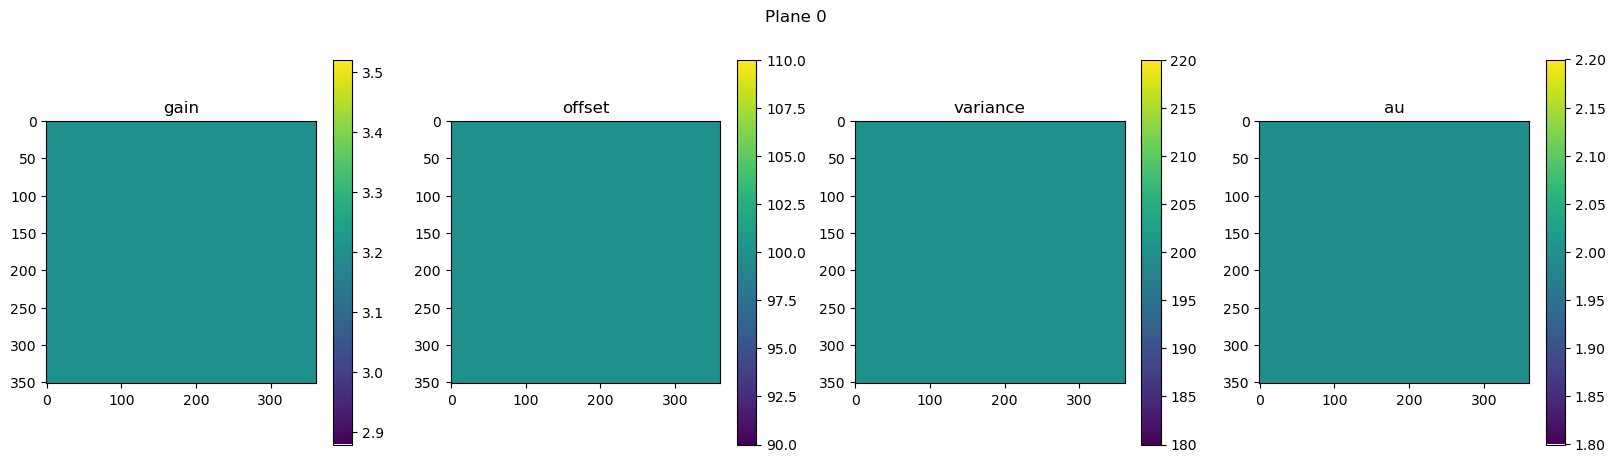

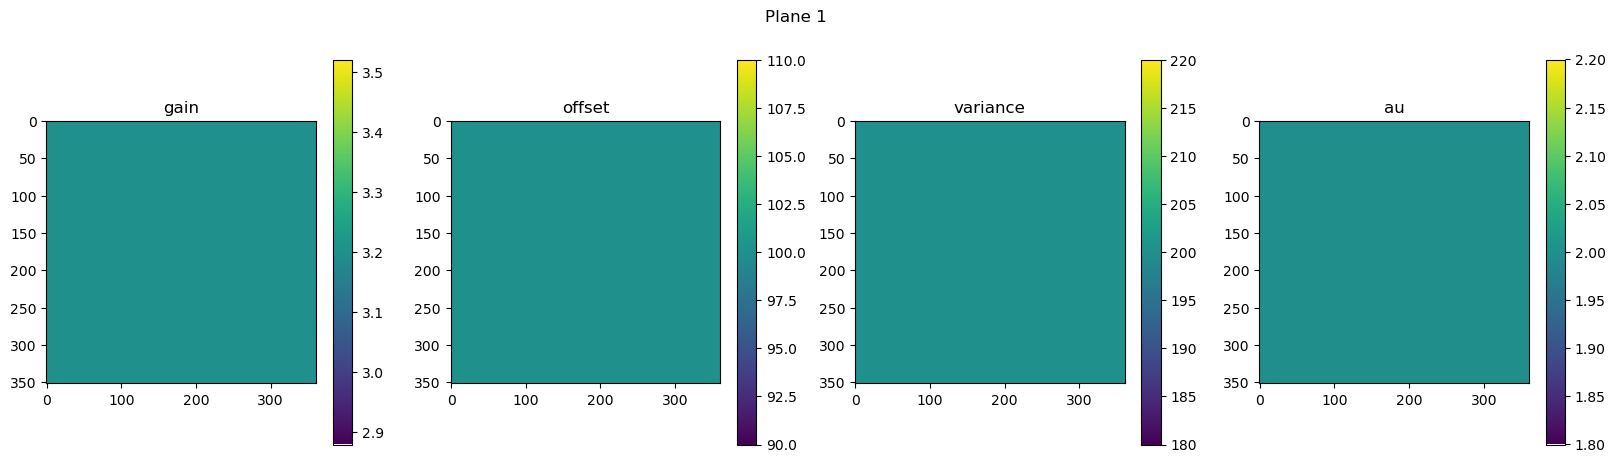

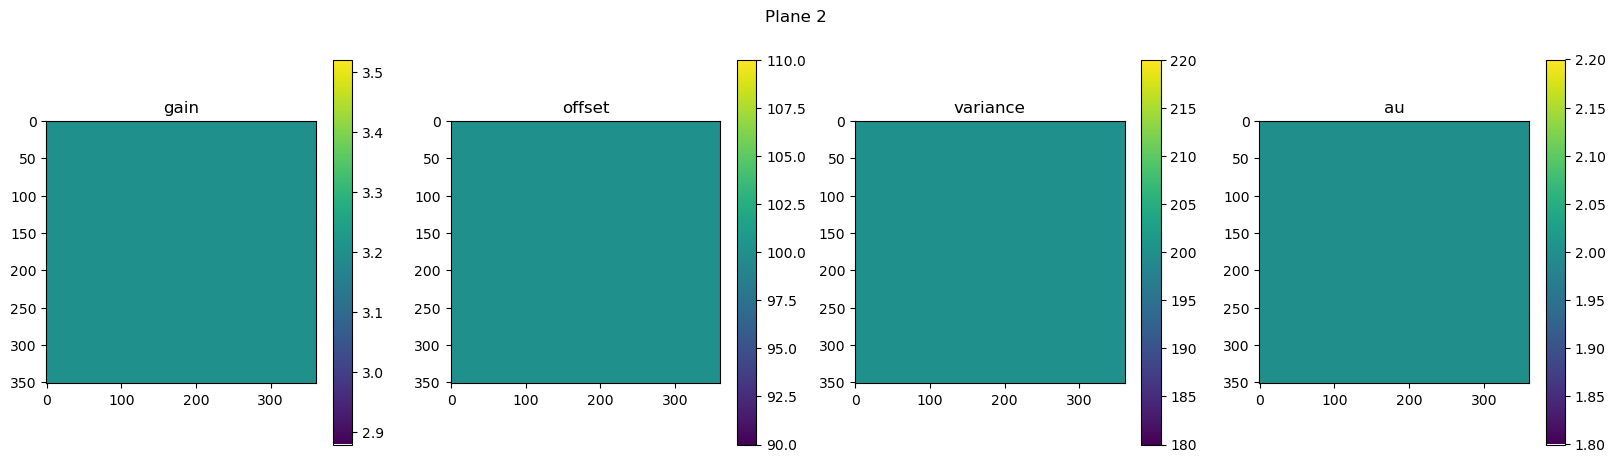

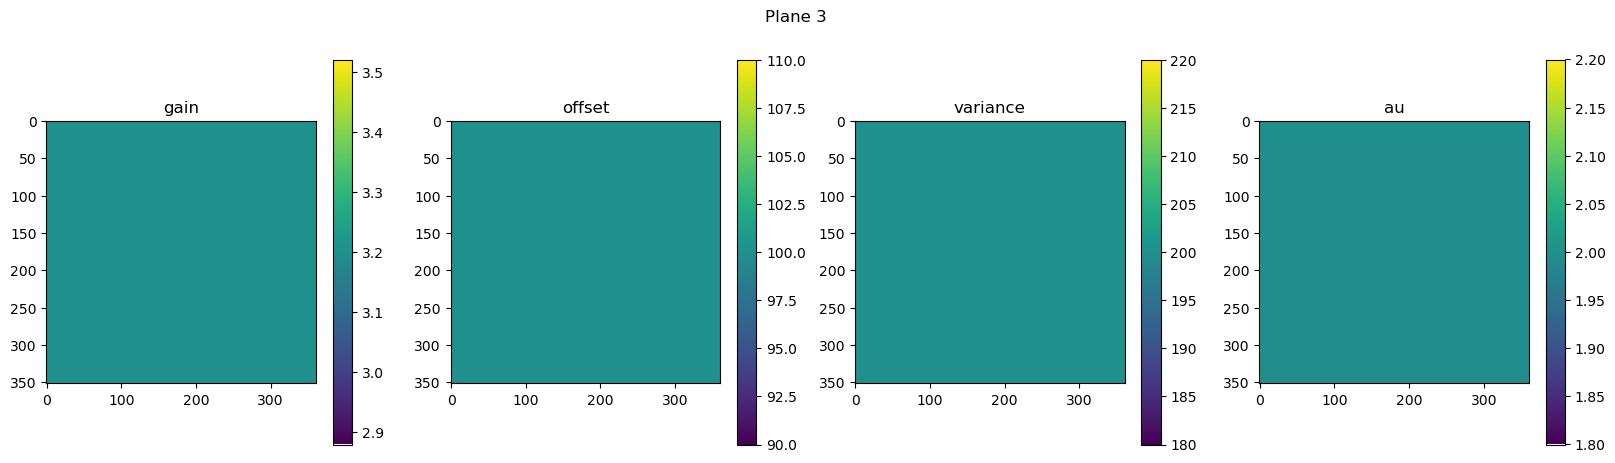

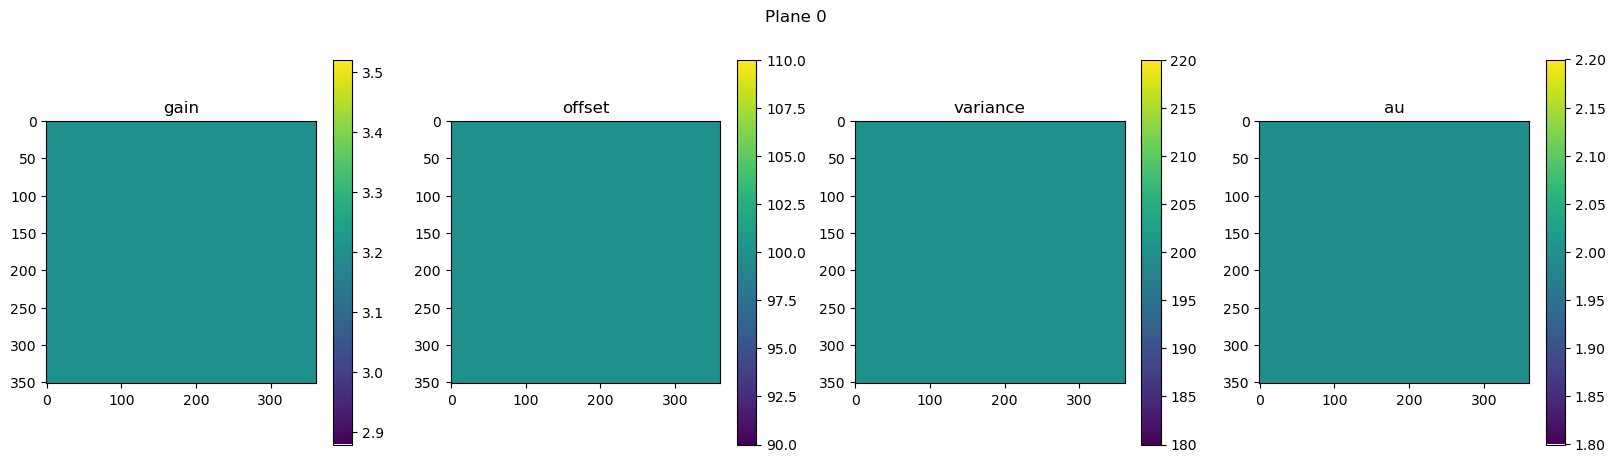

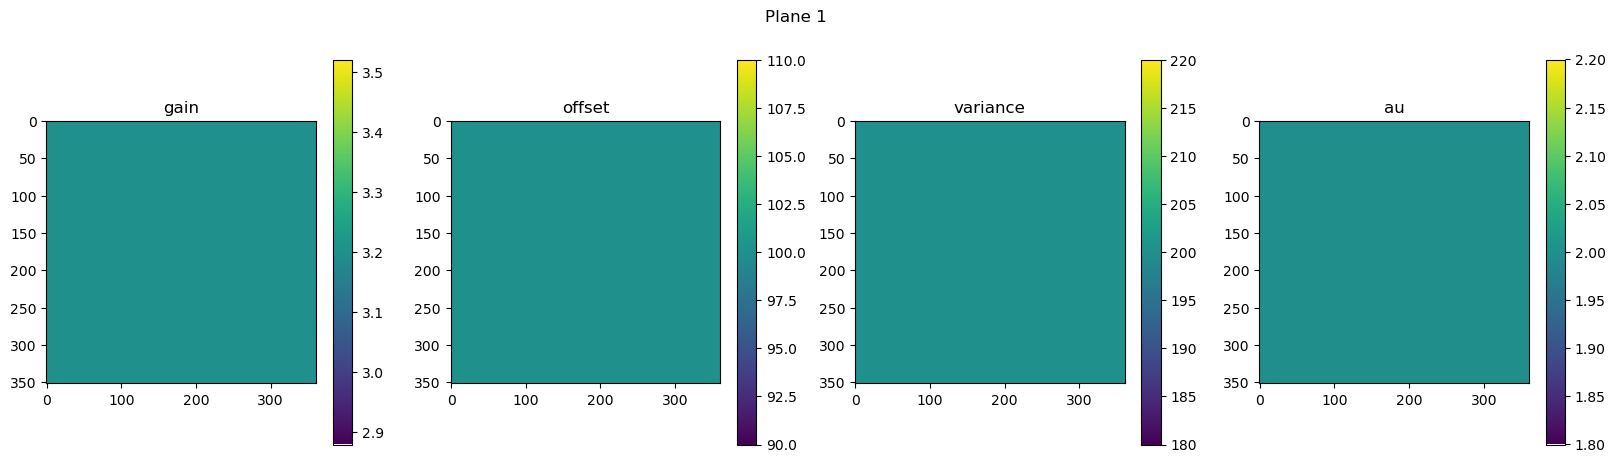

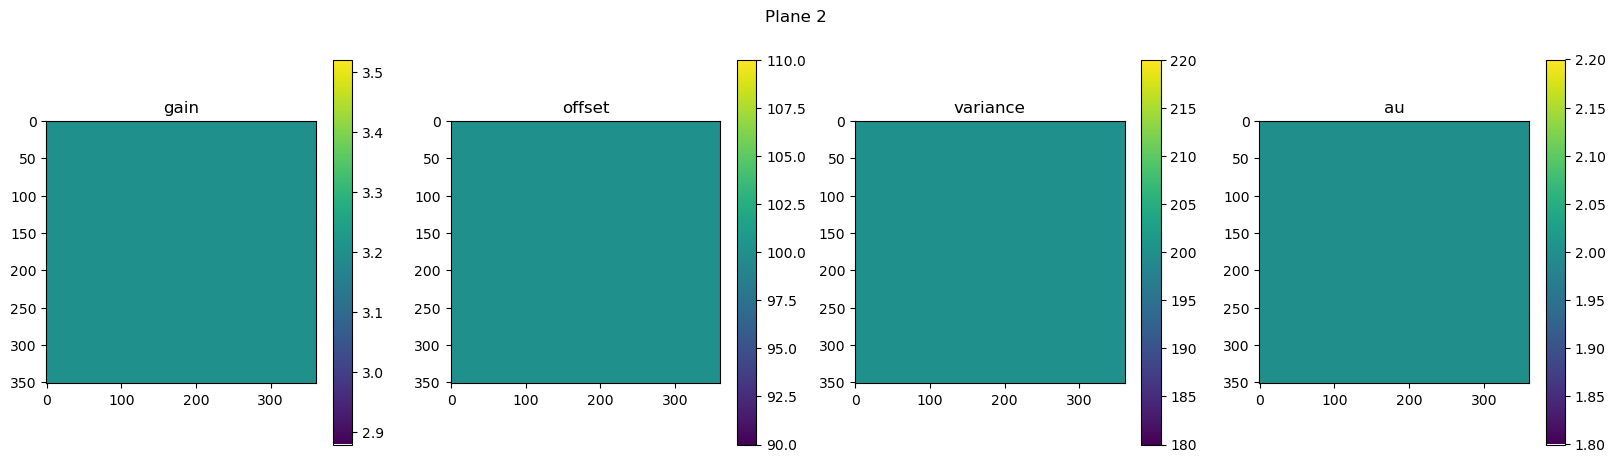

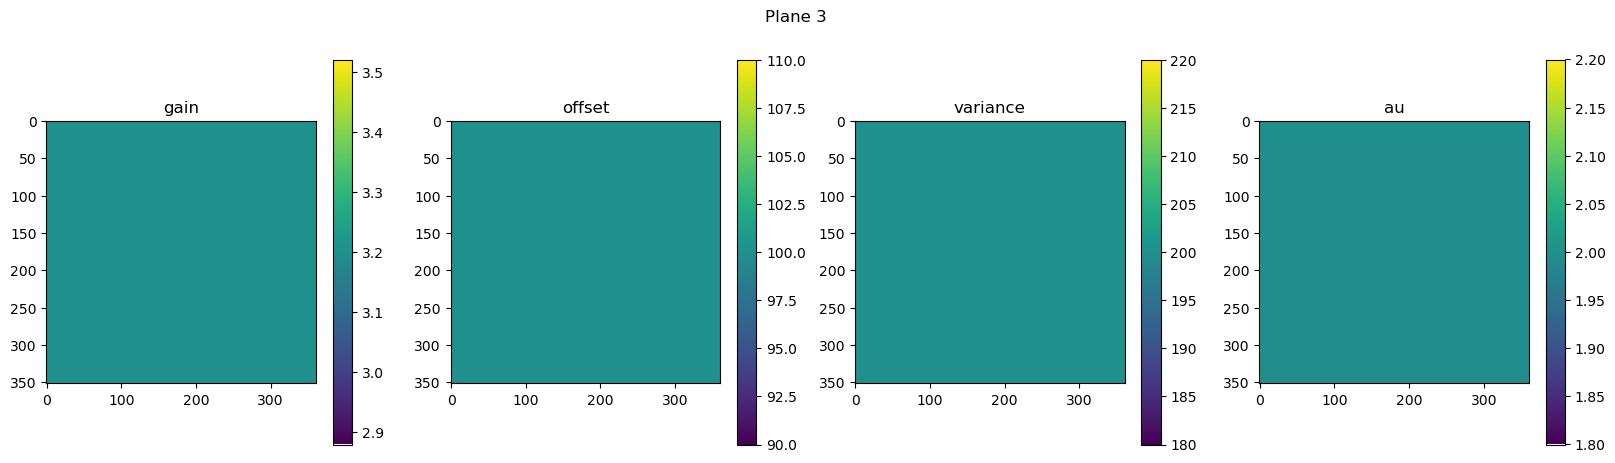

In [70]:
show_calib_data(cal1_dummy)
show_calib_data(cal2_dummy)